In [17]:
import os
import pandas as pd
import umap
import hdbscan
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
%pwd

'c:\\Users\\LENOVO\\InsightAI'

In [4]:
os.chdir('..')

In [5]:
%pwd

'c:\\Users\\LENOVO\\InsightAI'

In [19]:
# Load cleaned data
df = pd.read_csv('data/cleaned_data.csv')
texts = df['content'].tolist()

In [20]:
# Step 1: Sentence Embeddings (MiniLM)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

Batches: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


In [21]:
# Step 2: UMAP for Dimensionality Reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)

c:\Users\LENOVO\anaconda3\envs\insightenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\insightenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
# Step 3: SOM Topological Mapping
som_x, som_y = 10, 10  # Grid size
som = MiniSom(som_x, som_y, embeddings.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(embeddings)
som.train_batch(embeddings, 100)

som_coords = [som.winner(x) for x in embeddings]
som_xys = [x*som_y + y for x, y in som_coords]

In [23]:
# Step 4: Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(umap_embeddings)

c:\Users\LENOVO\anaconda3\envs\insightenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\insightenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
# Save labels
df['umap_x'] = umap_embeddings[:, 0]
df['umap_y'] = umap_embeddings[:, 1]
df['som_node'] = som_xys
df['cluster'] = labels

df.to_csv('data/clustered_tickets.csv', index=False)


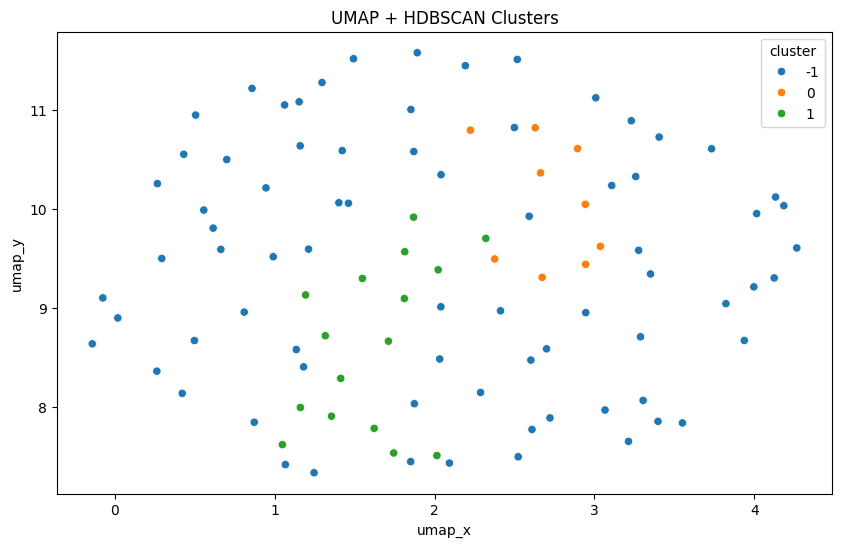

In [25]:
# Step 5: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='umap_x', y='umap_y', hue='cluster', data=df, palette='tab10')
plt.title('UMAP + HDBSCAN Clusters')
plt.show()

In [26]:
df.head()

,ticket_id,timestamp,source,department,content,umap_x,umap_y,som_node,cluster
0,TKT1000,2025-03-22 11:48:30,email,HR,dawn ochoa from wilcox inc in nguyenfort repor...,3.997432,9.211415,27,-1
1,TKT1001,2025-01-30 09:53:45,chat,Sales,robert smith from cruz ltd in east amanda repo...,3.037586,9.621330,99,0
2,TKT1002,2025-02-17 11:54:11,chat,Sales,steven king from paynefitzpatrick in new ashle...,1.870406,10.580005,78,-1
3,TKT1003,2025-03-01 20:47:38,email,Sales,timothy trevino from jones inc in heathchester...,0.615426,9.805511,93,-1
4,TKT1004,2025-05-08 19:58:59,call,Finance,pamela harris from johnson smith and wright in...,2.499672,10.822619,95,-1


In [27]:
df.tail()

,ticket_id,timestamp,source,department,content,umap_x,umap_y,som_node,cluster
95,TKT1095,2025-01-22 08:15:34,chat,Support,joshua reynolds from davis inc in north robert...,1.892032,11.579343,23,-1
96,TKT1096,2025-05-27 05:24:38,email,IT,brooke brooks from smith inc in port arielberg...,3.276814,9.581291,74,-1
97,TKT1097,2025-06-03 00:46:31,email,Finance,kimberly clark from mooregarcia in west jonath...,1.873853,8.029946,40,-1
98,TKT1098,2025-02-12 21:44:25,email,IT,benjamin taylor from martin ltd in lake jacobs...,2.663413,10.364415,45,0
99,TKT1099,2025-05-30 00:55:24,email,Finance,billy larson from burgess group in south victo...,4.184938,10.032209,41,-1
